# Assignment 1

**Course:** Introdução ao Processamento Digital de Imagem (MO443)  
**Goal:** To implement numeric operations over images using Python programming language  
**Author:** Lucas Oliveira David, 188972 --- <lucas.david@ic.unicamp.br>

In [1]:
class Config:
    image_sizes = (300, 300)
    images_used = 10
    
    buffer_size = 8 * images_used
    seed = 6714

## Setup

In [2]:
from math import ceil

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [3]:
def preprocessing_fn(image, label):
  # Adjust the image to be at least of size `Config.image_sizes`, which
  # garantees the random_crop operation below will work.
  current = tf.cast(tf.shape(image)[:2], tf.float32)
  target = tf.convert_to_tensor(Config.image_sizes, tf.float32)
  ratio = tf.reduce_max(tf.math.ceil(target / current))
  new_sizes = tf.cast(current*ratio, tf.int32)

  image = tf.image.resize(image, new_sizes, preserve_aspect_ratio=True)

  # Crop randomly.
  image = tf.image.resize_with_crop_or_pad(image, *Config.image_sizes)

  return image, label

In [4]:
def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    cmap=None,
    figsize=(14, 6)
):
  if image is not None:
    if isinstance(image, list) or len(image.shape) > 3:  # many images
      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

In [5]:
(train_ds,), info = tfds.load(
  'tf_flowers',
  split=['train[:1%]'],
  with_info=True,
  as_supervised=True)

int2str = info.features['label'].int2str

images_set = (train_ds
              .shuffle(Config.buffer_size, Config.seed)
              .map(preprocessing_fn, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(Config.images_used)
              .take(1))

images, target = next(iter(images_set))
images = tf.cast(images, tf.float32)
labels = [int2str(l) for l in target]

## TF-Flowers (Image Dataset)

We utilize 10 random images from the [TF-Flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset, which can be downloaded in the tf-records format using the `tensorflow-datasets` library.

This dataset represents a multi-class (mono-label) image classification problem, and comprises 3,670 photographs of flowers associated with one of the following labels: *dandelion*, *daisy*, *tulips*, *sunflowers* or *roses*.

During the loading procedure, 1% of the set is retrieved from the disk (approximately 37 samples). Samples are shuffled and the first batch of 10 images is retrieved. In these settings:

- 3,670 images are downloaded into disk (compressed tf-record format)
- 37 (approx.) references --- consisting of filepaths and record shard-level address --- are loaded into memory
- 10 samples and labels are effectively loaded into memory

Images are represented by tensors of rank 3, of shape `(HEIGHT, WIDTH, 3)`.
They are first loaded into memory as n-dimensional arrays of type `tf.uint8`. As many of the following operations are floating point precision, we opted to cast them imediately to `tf.float32`. This is the default dtype for most operations in TensorFlow graphs.

Image may have different sizes, which prevents them from being directly stacked into a 4-rank tensor `(BATCH, HEIGHT, WIDTH, 3)`. We circumvented this problem using the following procedure: 

1. Let $Q := (300, 300, 3)$ be a desired output shape and $S_I := (H, W, 3)$ be the actual shape of any given image $I$.  
$I$ is resized so it's smallest component (width or height) would match the smallest component of $Q$ (namely, 300), resulting in $I'$.

2. The largest component in the shape of $I'$ is now greater or equal to $300$. We extract the central crop of size $(300, 300)$ from $I'$, resulting inadvertly in an image of shape $(300, 300, 3)$.

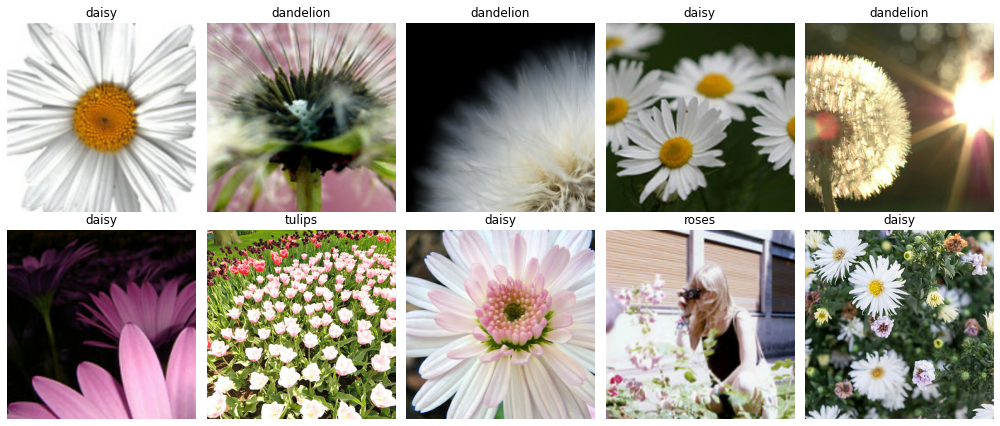

In [6]:
#@title

visualize(
  tf.cast(images, tf.uint8),
  labels
)

Fig. 1: Images from TF-Flowers

## 1.1 Colors Images

### A) Sepia

**Q:** Execute the following operations over the images:

    R’ = 0.393R + 0.769G + 0.189B
    G’ = 0.349R + 0.686G + 0.168B
    B’ = 0.272R + 0.534G + 0.131B

One way to perform this is to separate the image tensor $I$ of shape `(B, H, W, 3)`  by its last axis, forming three tensors of shape `(B, H, W, 1)`.
We multiply each and every component according to the rule above and concatenate the result:

In [7]:
@tf.function
def sepia(x):
  x = tf.cast(x, tf.float32)

  r, g, b = tf.split(x, 3, axis=-1)

  y = tf.concat((0.393*r + 0.769*g + 0.189*b,
                 0.349*r + 0.686*g + 0.168*b,
                 0.272*r + 0.534*g + 0.131*b),
                axis=-1)

  return tf.clip_by_value(y, 0, 255)

A more ellegant solution is to remember that every linear system (including $(R', G', B')^\intercal$, described above) can be interpreted as a multiplication between the input matrix and a coefficient matrix:

\begin{align}
X \cdot S &= \begin{bmatrix}
              \sum_k x_{0,k} s_{k,0} & ... & \sum_k \space x_{0,k}s_{k,m} \\
              ... & ... & ... \\
              \sum_k x_{n,k} s_{k,0} & ... & \sum_k \space x_{n,k}s_{k,m} \\
            \end{bmatrix} \\
\begin{bmatrix}
R & G & B
\end{bmatrix} \cdot \begin{bmatrix}
0.393 & 0.349 & 0.272 \\
0.769 & 0.686 & 0.534 \\
0.189 & 0.168 & 0.131 \\
\end{bmatrix} &= \begin{bmatrix}
                   0.393R + 0.769G + 0.189B \\
                   0.349R + 0.686G + 0.168B \\
                   0.272R + 0.534G + 0.131B
                 \end{bmatrix}^T
\end{align}

In our case, $I$ has rank 4 (not a matrix), but the same equivalence applies, as the matrix multiplication is a specific case of the tensor dot product.
There are multiple ways to perform this operation in Tensorflow:

1. `y = tf.matmul(x, s)`: inner-product over the inner-most indices in the input tensors (last axis of `x` and antepenultimate axis of `s`). This assumes the other axes represent batch-like information, and generalizes the matrix-multiplication operation for all cases (the input is a matrix, batch of matrix or batch of sequence of matrix, ...).

2. `y = x @ s`: override of `tf.matmul`, same resulting operation

3. `y = tf.tensorproduct(x, s, 1)`: the tensor dot product over one rank (the last in `x` and first in `sepia_weights`):

4. `y = tf.einsum('bhwc,ck->bhwk', x, s)`: Einstein's summation over the rank `c` (last in `x` and first in `s`)

In [8]:
sepia_weights = tf.constant(
  [[0.393, 0.349, 0.272],
   [0.769, 0.686, 0.534],
   [0.189, 0.168, 0.131]]
)

@tf.function
def sepia(x):
  y = x @ sepia_weights
  return tf.clip_by_value(y, 0, 255)


transformed = sepia(images)

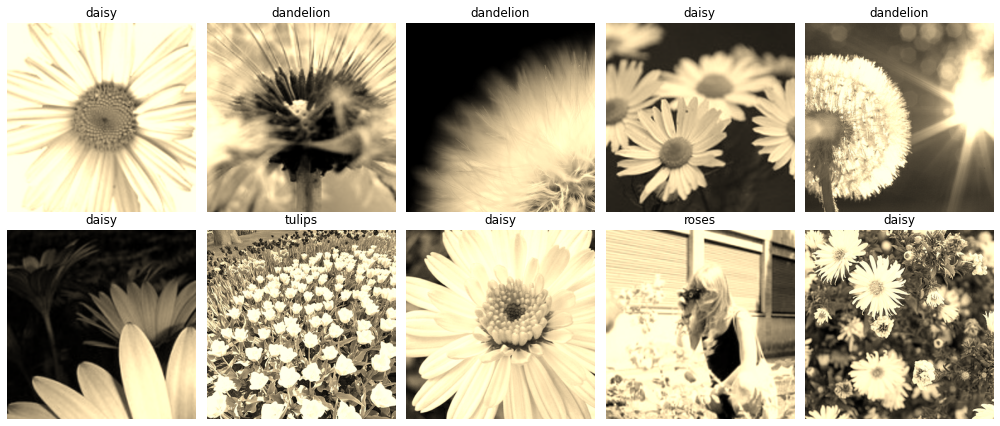

In [9]:
#@title

visualize(
  tf.cast(transformed, tf.uint8),
  labels
)

Fig. 2: Images transformed with the Sepia filter

### B) Gray-scale

**Q:** Dada uma imagem colorida no formato RGB, altere a imagem tal que ela contenha apenas uma banda de cor, cujos valores são calculados pela média ponderada:

    I = 0.2989R + 0.5870G + 0.1140B

The solution is very similar to what was done in **a)**, except that the coefficient tensor is no longer a matrix, which preclude the usage of `@`.
We use `tf.tensordot` to compute the inner product between the last axis of `x` and first (and only) axis of `gray_weights`.

An acceptable alternative form would be `tf.einsum('bhwc,c->bhw', x, gray_weights)`.

In [10]:
gray_weights = tf.constant([0.2989, 0.5870, 0.1140])

@tf.function
def grayscale(x):
  y = tf.tensordot(x, gray_weights, 1)
  y = tf.expand_dims(y, -1)             # restore 3rd rank (H, W, 1)
  return tf.clip_by_value(y, 0, 255)

images_g = grayscale(images)

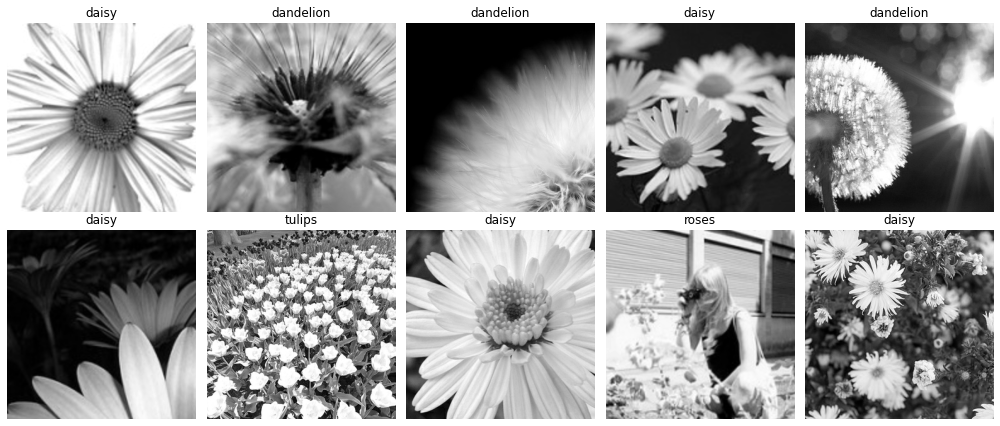

In [11]:
#@title


visualize(
  tf.cast(images_g, tf.uint8),
  labels,
  cmap='gray'
)

Fig. 3: Images transformed to Gray-scale

## 1.2 Monochromatic Images

**Q:** Apply the following filters to the monochromatic images.

In [12]:
h17 = tf.constant(
  [
    [[-1., 0., 1.],
     [-2., 0., 2.],
     [-1., 0., 1.]],

    [[-1., -2., -1.],
     [ 0.,  0.,  0.],
     [ 1.,  2.,  1.]],

    [[-1., -1., -1.],
     [-1.,  8., -1.],
     [-1., -1., -1.]],
   
    [[1/9, 1/9, 1/9],
     [1/9, 1/9, 1/9],
     [1/9, 1/9, 1/9]],

    [[-1., -1.,  2.],
     [-1.,  2., -1.],
     [ 2., -1., -1.]],

    [[ 2., -1., -1.],
     [-1.,  2., -1.],
     [-1., -1.,  2.]],

    [[ 0., 0., 1.],
     [ 0., 0., 0.],
     [-1., 0., 0.]],
  ]
)

h8 = tf.constant(
  [[ 0.,  0., -1.,  0.,  0.],
   [ 0., -1., -2., -1.,  0.],
   [-1., -2., 16., -2., -1.],
   [ 0., -1., -2., -1.,  0.],
   [ 0.,  0., -1.,  0.,  0.]]
)

h9 = 1/256 * tf.constant(
  [[1.,  4.,  6.,  4., 1.],
   [4., 16., 24., 16., 4.],
   [6., 24., 36., 24., 6.],
   [4., 16., 24., 16., 4.],
   [1.,  4., 16.,  4., 1.]]
)

h89 = tf.stack((h8, h9), axis=0)

h17 = tf.transpose(h17, (1, 2, 0))
h89 = tf.transpose(h89, (1, 2, 0))

#### TensorFlow Native Conv2D Implementation

The convolution of a 1-D input sinal $f$ and a 1-D kernel $g$ is defined as the integration of the product between the two signals, when evaluated over the temporal component:

$$
(f*g)(t) = \int f(\tau)g(t - \tau) d\tau
$$

We observe from the equation above that one of the signals is reflected. This is essential so both functions are evaluated over the same time interval, resulting in the effect of "zipping" the two functions together.
This effect is illustrated in the first column of Fig. 4.

On the other hand, *Cross-correlation* is a similar operation in which $g$ slides over $f$ without the aforementioned reflection:

$$
(f*g)(t) = \int f(\tau)g(t + \tau) d\tau
$$

The signals are associated in an inverted fashion, which is illustrated in the second column of Fig. 4.

Finally, we can imagine that a 2-D signal (such as images) is reflected when both $(x, y)$ axes are reflected. This is equivalent of rotating the image in $180^\circ$.

<figure>
  <img title="Comparison between convolution, cross-correlation and autocorrelation. From Wikipedia."
      src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Comparison_convolution_correlation.svg/1280px-Comparison_convolution_correlation.svg.png"
      width="400px"
      />
</figure>

Fig. 4: Comparison between convolution, cross-correlation and autocorrelation. From <a href="https://en.wikipedia.org/wiki/Cross-correlation">Wikipedia</a>.

Notwithstanding its name, the `tf.nn.conv2d(f, g)` function implements the cross-correlation function, and the convolution operation is supposedly performed by assuming the kernel $g$ is already reflected.

In the example below, we observe the output signal is obtained by the *Cross-correlation* eq.:

In [13]:
s = tf.constant(
  [[1., 2., 3.],
   [4., 5., 6.],
   [7., 8., 9.]]
)
k = tf.constant(
  [[1., 1.],
   [0., 0.]]
)
c = tf.nn.conv2d(
  tf.reshape(s, (1, 3, 3, 1)),
  tf.reshape(k, (2, 2, 1, 1)),
  strides=1,
  padding='VALID'
)

print('signal:', s.numpy(), sep='\n')
print('kernel:', k.numpy(), sep='\n')
print('s*k:', tf.reshape(c, (2, 2)).numpy(), sep='\n')

signal:
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
kernel:
[[1. 1.]
 [0. 0.]]
s*k:
[[ 3.  5.]
 [ 9. 11.]]


This is a design decision which takes performance into account, as the rotation operations can be omitted during the feed-forward process. During training, kernels are correctly learnt through back-propagation by minimizing a given loss function (e.g. cross-entropy, N-pairs, focal loss).
Interestingly enough, the differential of the **real-valued** cross-correlation with respect to its kernel (which is used to update the kernels) is the cross-correlation itself, rotated $180^\circ$ (e.g. convolution).

In this case, in which the kernels are fixed, we assume they represent regular filters.
We therefore rotate the kernels them before applying the `tf.nn.conv2d` function.

This assignment can be trivially solved using this function:

In [14]:
def to_kernel(k):
  if len(k.shape) == 2: k = k[..., tf.newaxis]
  if len(k.shape) == 3: k = k[..., tf.newaxis, :]
  
  k = tf.image.rot90(k, 2)

  return k

y17 = tf.nn.conv2d(images_g, to_kernel(h17), 1, 'SAME')
y89 = tf.nn.conv2d(images_g, to_kernel(h89), 1, 'SAME')

yr1c2 = tf.sqrt(
  tf.nn.conv2d(images_g, to_kernel(h17[..., 0]), 1, 'SAME')**2 +
  tf.nn.conv2d(images_g, to_kernel(h17[..., 1]), 1, 'SAME')**2
)

y = tf.concat((y17, y89, yr1c2), axis=-1)
y = tf.clip_by_value(y, 0, 255)

### Vectorized Cross-correlation Implementation

#### Study of a Prime-Shaped Use-Case

In [15]:
s = np.arange(70).reshape(2, 7, 5) + 1
k = np.asarray(
  [
    [[0., 2., 1.],
     [0., 1., 0.]],

    [[0., 0., 0.],
     [0., 1., 2.]]
  ]
).transpose(1, 2, 0)

B, H, W = s.shape
KH, KW, KC = k.shape

In [16]:
r0 = np.arange(H-KH+1)
r0 = np.repeat(r0, W-KW+1)
r0 = r0.reshape(-1, 1)
r0

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [3],
       [3],
       [3],
       [4],
       [4],
       [4],
       [5],
       [5],
       [5]])

In [17]:
r1 = np.arange(KH).reshape(1, KH)
r1

array([[0, 1]])

In [18]:
r = np.repeat(r0 + r1, KW, axis=1)
r

array([[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [1, 1, 1, 2, 2, 2],
       [1, 1, 1, 2, 2, 2],
       [1, 1, 1, 2, 2, 2],
       [2, 2, 2, 3, 3, 3],
       [2, 2, 2, 3, 3, 3],
       [2, 2, 2, 3, 3, 3],
       [3, 3, 3, 4, 4, 4],
       [3, 3, 3, 4, 4, 4],
       [3, 3, 3, 4, 4, 4],
       [4, 4, 4, 5, 5, 5],
       [4, 4, 4, 5, 5, 5],
       [4, 4, 4, 5, 5, 5],
       [5, 5, 5, 6, 6, 6],
       [5, 5, 5, 6, 6, 6],
       [5, 5, 5, 6, 6, 6]])

In [19]:
c0 = np.arange(KW)
c0 = np.tile(c0, KH).reshape(1, -1)
c0

array([[0, 1, 2, 0, 1, 2]])

In [20]:
c1 = np.arange(W-KW+1).reshape(-1, 1)
c1

array([[0],
       [1],
       [2]])

In [21]:
c = c0 + c1
c = np.tile(c, [H-KH+1, 1])
c

array([[0, 1, 2, 0, 1, 2],
       [1, 2, 3, 1, 2, 3],
       [2, 3, 4, 2, 3, 4],
       [0, 1, 2, 0, 1, 2],
       [1, 2, 3, 1, 2, 3],
       [2, 3, 4, 2, 3, 4],
       [0, 1, 2, 0, 1, 2],
       [1, 2, 3, 1, 2, 3],
       [2, 3, 4, 2, 3, 4],
       [0, 1, 2, 0, 1, 2],
       [1, 2, 3, 1, 2, 3],
       [2, 3, 4, 2, 3, 4],
       [0, 1, 2, 0, 1, 2],
       [1, 2, 3, 1, 2, 3],
       [2, 3, 4, 2, 3, 4],
       [0, 1, 2, 0, 1, 2],
       [1, 2, 3, 1, 2, 3],
       [2, 3, 4, 2, 3, 4]])

In [22]:
y = (s[..., r, c] @ k.reshape(-1, KC)).reshape(B, H-KH+1, W-KW+1, KC)
y.shape

(2, 6, 3, 2)

#### Implementation

In [23]:
from math import ceil, floor

_PADDINGS = ('VALID', 'SAME')

def _validate_correlate2d_args(s, k, padding):
  assert padding in _PADDINGS, (f'Unknown value {padding} for argument `padding`. '
                                f'It must be one of the following: {_PADDINGS}')
  assert len(s.shape) == 3, (f'Input `s` must have shape [B, H, W]. '
                             f'A tensor of shape {s.shape} was passed.')
  assert len(k.shape) == 3, (f'Kernels `k` must have shape [H, W, C]. '
                             f'A tensor of shape {k.shape} was passed.')


def correlate2d(s, k, padding='VALID'):
  s, k = map(np.asarray, (s, k))
  _validate_correlate2d_args(s, k, padding)

  B, H, W = s.shape
  KH, KW, KC = k.shape

  if padding == 'SAME':
    pt, pb = floor((KH-1)/2), ceil((KH-1)/2)
    pl, pr = floor((KW-1)/2), ceil((KW-1)/2)

    s = np.pad(s, ((0,0), (pt, pb), (pl, pr)))
    B, H, W = s.shape
  
  # Creating selection tile s[0:3, 0:3]
  #   --> [s[0,0], s[0,1], s[0,2], s[1,0], s[1,1], s[1,2]]
  r0 = np.arange(H-KH+1)
  r0 = np.repeat(r0, W-KW+1)
  r0 = r0.reshape(-1, 1)

  r1 = np.arange(KH).reshape(1, KH)
  r = np.repeat(r0 + r1, KW, axis=1)

  c0 = np.arange(KW)
  c0 = np.tile(c0, KH).reshape(1, -1)

  c1 = np.arange(W-KW+1).reshape(-1, 1)
  c = c0 + c1
  c = np.tile(c, [H-KH+1, 1])

  # k.shape (3, 3) --> (9, 1), in order to multiply
  # and add-reduce in a single pass with "@".
  y = s[..., r, c] @ k.reshape(-1, KC)
  y = y.reshape(B, H-KH+1, W-KW+1, KC)

  return y

def convolve2d(s, k, padding='VALID'):
  k = np.rot90(k, k=2)  # reflect signal.
  return correlate2d(s, k, padding)

#### Testing My Implementation Against Scipy's

In [24]:
import scipy.signal

for padding in ('valid', 'same'):
  y_mine = correlate2d(s, k, padding=padding.upper())
  y_scipy = np.asarray(
    [
      [scipy.signal.correlate2d(s[b], k[..., c], mode=padding.lower())
       for c in range(k.shape[-1])]
      for b in range(s.shape[0])
    ]
  ).transpose(0, 2, 3, 1)  # transpose to (B, H, W, C) format.

  np.testing.assert_almost_equal(
    y_mine,
    y_scipy
  )

print('All tests passed (no exceptions raised).')

All tests passed (no exceptions raised).


#### Application over the Image Samples

In [25]:
y = np.concatenate(
  (convolve2d(images_g[..., 0].numpy(), h17, padding='SAME'),
   convolve2d(images_g[..., 0].numpy(), h89, padding='SAME')),
  axis=-1
)

yr1c1 = np.sqrt(
  convolve2d(images_g[..., 0].numpy(), h17[..., 0:1], padding='SAME')**2
  + convolve2d(images_g[..., 0].numpy(), h17[..., 1:2], padding='SAME')**2
)

y = np.concatenate((y, yr1c2), axis=-1)

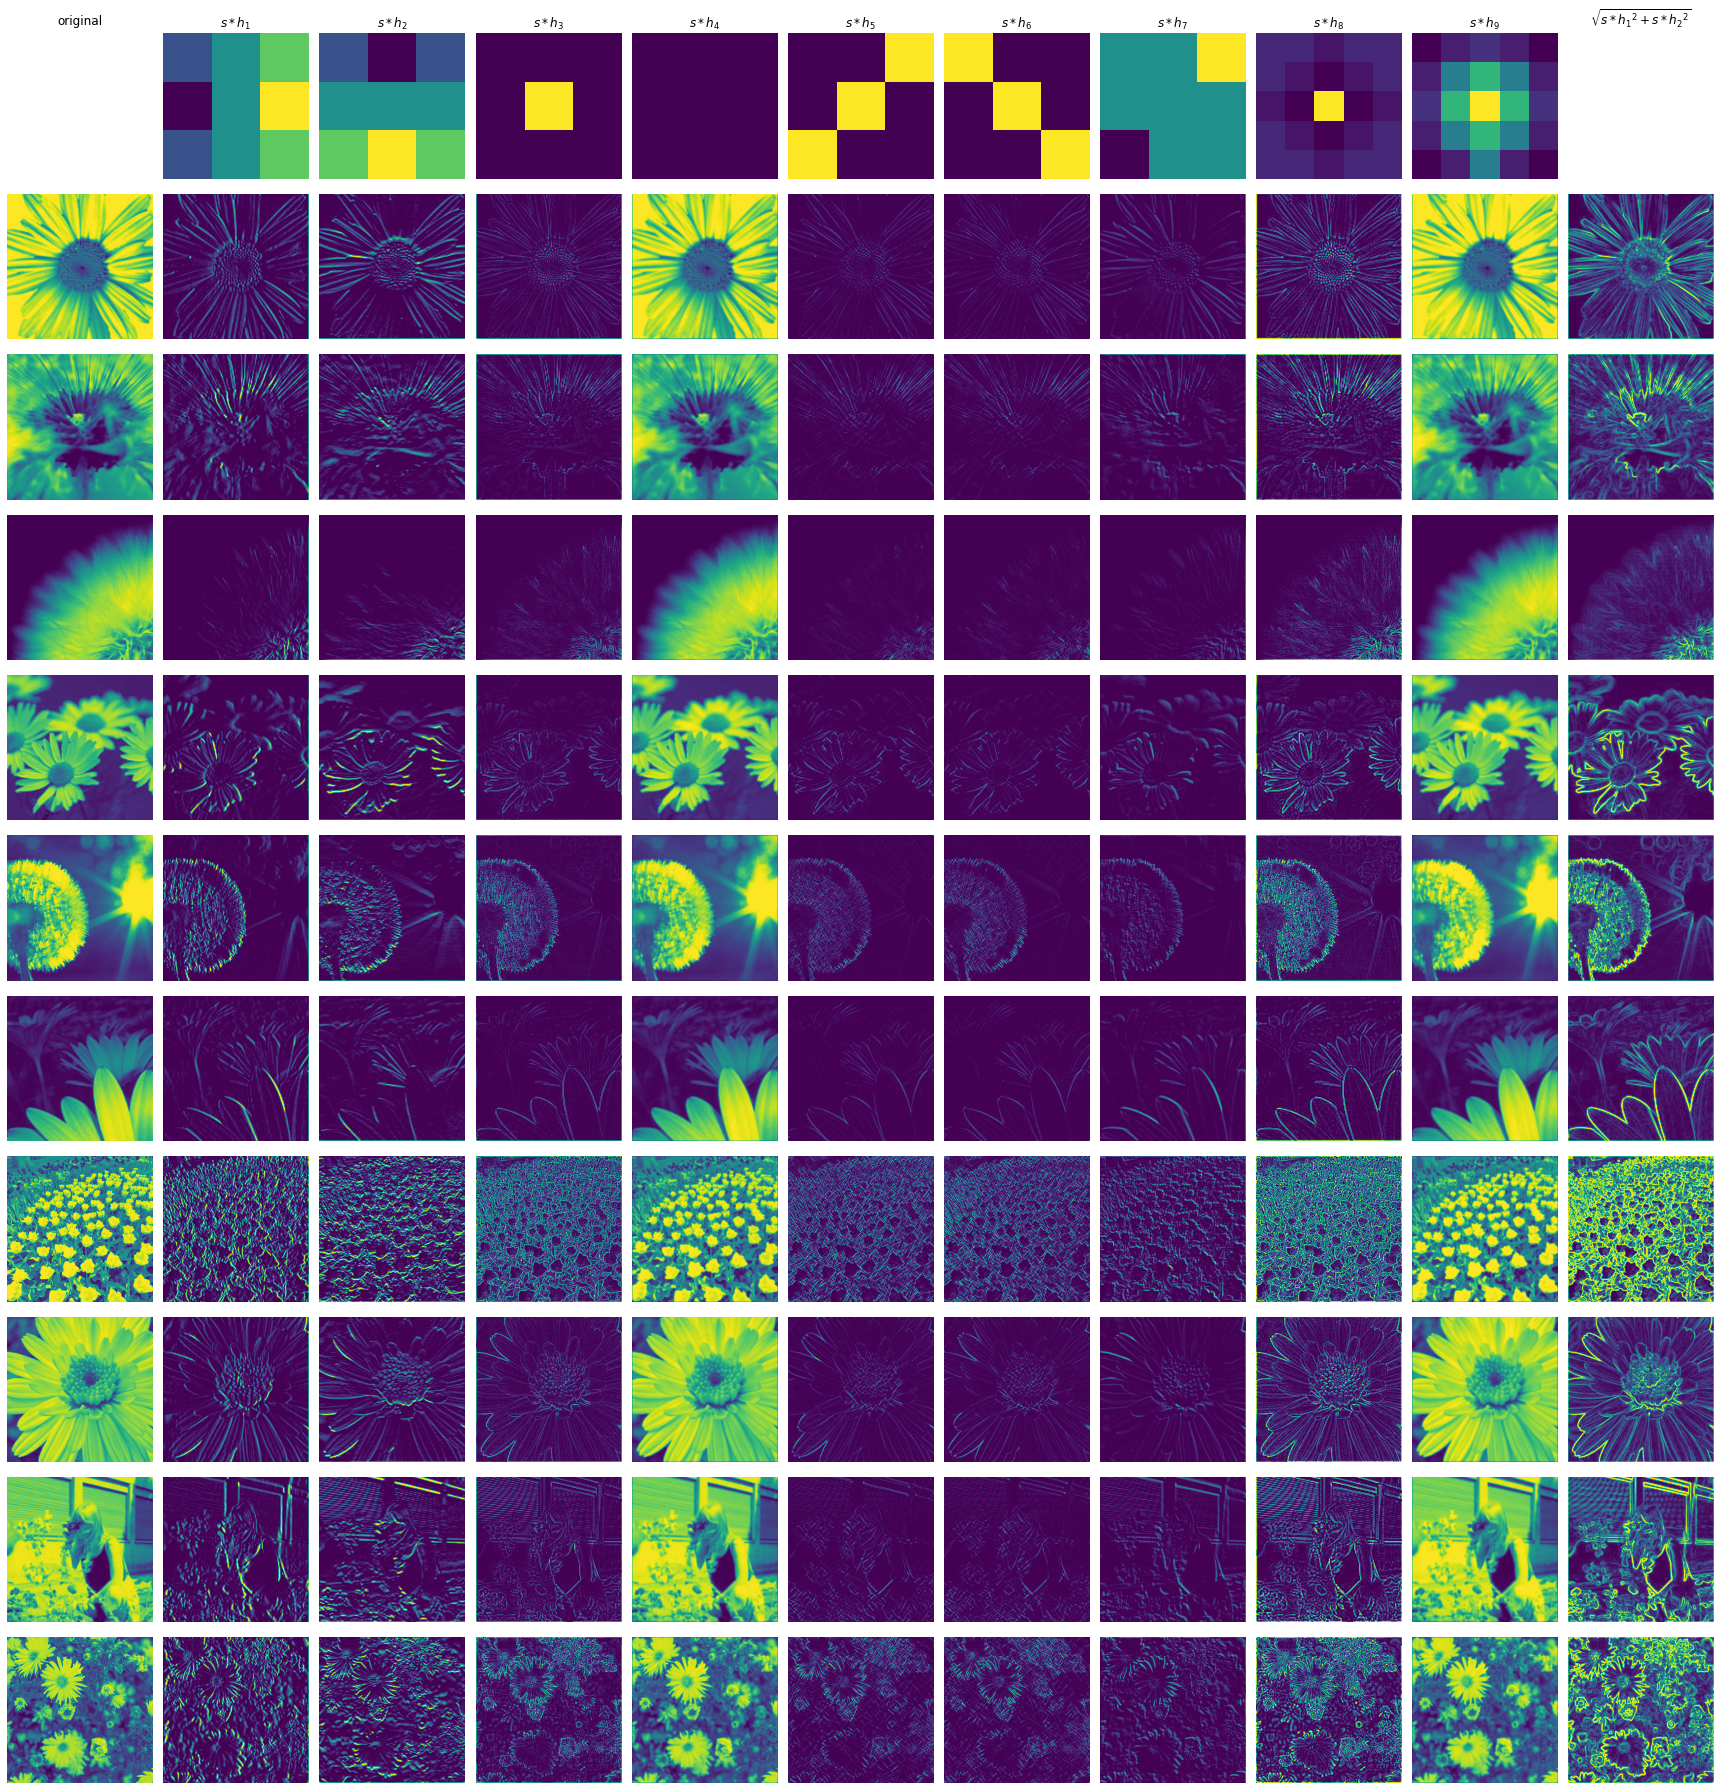

In [26]:
#@title

visualizing = tf.cast(
  tf.clip_by_value(
    tf.reshape(
      tf.transpose(tf.concat((images_g, y), axis=-1), (0, 3, 1, 2)),
      (-1, *images_g.shape[1:])
    ),
    0,
    255
  ),
  tf.uint8
).numpy()

visualizing = [
  None,  # empty cell (original images column)
  *tf.transpose(h17, (2, 0, 1)).numpy(),  # kernels 1 through 7
  *tf.transpose(h89, (2, 0, 1)).numpy(),  # kernels 8 and 9
  None,  # empty cell (sqrt(s*h1^2+s^h2^2) column)
  *visualizing # images and convolution results
]

titles = [
  'original',
  *(f'$s*h_{i+1}$' for i in range(9)),
  '$\sqrt{{s*h_1}^2 + {s*h_2}^2}$',
]

visualize(
  visualizing,
  titles,
  rows=images_g.shape[0] + 1,
  cols=y.shape[-1] + 1,
  figsize=(24, 25),
)